In [1]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
#import tensorflow as tf
import numpy as np
#import scipy.special as sci
import matplotlib.pyplot as plt
import pickle#5 as pickle
from scipy.linalg import expm, sinm, cosm,pinv
from numpy import linalg as LA
from sympy import *
from sklearn.decomposition import PCA
from scipy import integrate
import numpy.matlib as npm
import matplotlib as mpl
import pandas as pd

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "0" 

In [3]:
def neural_net(X, weights, biases):
    num_layers = len(weights) + 1  
    H=X
#    H = 2.0*(X -  X.min(0))/( X.max(0) -  X.min(0)) - 1.0
    for l in range(0,num_layers-2):
        W = weights[l]
        b = biases[l]
        H = tf.nn.tanh(tf.add(tf.matmul(H, W), b))
    W = weights[-1]
    b = biases[-1]
    Y =   tf.add(tf.matmul(H, W), b)
    return Y


def neural_net1(X, weights, biases):
    num_layers = len(weights) + 1  
    H=X
#    H = 2.0*(X -  X.min(0))/( X.max(0) -  X.min(0)) - 1.0
    for l in range(0,num_layers-2):
        W = weights[l]
        b = biases[l]
        H = tf.nn.tanh(tf.add(tf.matmul(H, W), b))
    W = weights[-1]
    b = biases[-1]
    Y =  tf.exp(     tf.add(tf.matmul(H, W), b)   )
    return Y

def xavier_init(size):
    in_dim = size[0]
    out_dim = size[1]        
    xavier_stddev = np.sqrt(2.0/(in_dim + out_dim))
    return tf.Variable(tf.truncated_normal([in_dim, out_dim], stddev=xavier_stddev,dtype=tf.float32,seed=0), dtype=tf.float32)

In [4]:
def neural_net_g(t, weights_g1, biases_g1, weights_g2, biases_g2):
    g1= neural_net1(t, weights_g1, biases_g1 )
    g2= neural_net1(t, weights_g2, biases_g2 )
    return g1,g2

# def neural_net_phi(t, weights, biases):
#     v= neural_net(t, weights, biases)
#     return v
def neural_net_phi(t, weights_phi1, biases_phi1, weights_phi2, biases_phi2):
    phi1= neural_net(t, weights_phi1, biases_phi1)   #*t*(t1-t)+(phi_R-phi_L)/(t1-t0)*t+phi_L
    phi2= neural_net(t, weights_phi2, biases_phi2)   #*t*(t1-t)+(phi_R-phi_L)/(t1-t0)*t+phi_L
    return phi1,phi2

def potential(x,y):
    gamma=10
    #U= -1/2*x**2+1/4*x**4+1/2*y**2+1/2*x**2*y**2
    U_x=x**3-x+gamma*x*y**2
    U_y=y+x**2*y
    return U_x,U_y

$$
        b(x,y)=\left(\begin{array}{c}
            x-x^{3}- \beta x y^{2} \\-\left(1+x^{2}\right) y\end{array}
            \right).
$$

\begin{equation*}
I_B(\varphi) \triangleq  \inf \left\{\int_{0}^{T} |g(s)|^2\textbf{} d s \mid g \in \mathcal{AC}(0,T): \varphi(t)=x+\int_{0}^{t} b(\varphi(s)) d s+\int_{0}^{t} \sigma(\varphi(s))g(s) d s, \quad t \in[0, T]\right\}
\end{equation*}

 \begin{align*}
        \varphi_1(t)  =& x_1^{(1)}+ \int_0^t \big(\varphi_1(s)-\varphi_1^3(s)-\varphi_1(s)\varphi_2^2(s) \big)ds \\
        & + \int_0^t  g_1(s)  ds, \\
        \varphi_2(t)  = &x_1^{(2)}- \int_0^t \big( 1+\varphi_1^2(s) \big) \varphi_2(s) ds \\
        &  + \int_0^t  g_2(s)    ds.    
    \end{align*}
where $g(s)=(g_1(s),g_2(s))$.
The object function is 
\begin{equation}
    \frac{1}{2}\int_0^T |g_1^2(s)+g_2^2(s))|^{\frac{1}{2}}ds.
\end{equation}

In [5]:
# def net_ode_int(x,y,t, weights_g,biases_g,alpha  ):
#     g= neural_net_g(x,y,t, weights_g, biases_g)
#     f1=x*(g-1) *tf.exp(-( x**2+y**2  )**(alpha/2 ) )
#     f2=y*(g-1) *tf.exp(-( x**2+y**2  )**(alpha/2 )  )
#     return f1,f2
def net_ode_phi(t, weights_phi1, biases_phi1, weights_phi2, biases_phi2 ):
    phi1=neural_net_phi(t, weights_phi1,biases_phi1  , weights_phi2, biases_phi2)[0]
    phi2=neural_net_phi(t, weights_phi1,biases_phi1  , weights_phi2, biases_phi2)[1]
    phi1_t = tf.gradients(phi1, t)[0]
    phi2_t = tf.gradients(phi2, t)[0]
    U_x=potential( phi1, phi2)
    g1=neural_net_g(t, weights_g1, biases_g1, weights_g2, biases_g2)[0]
    g2=neural_net_g(t, weights_g1, biases_g1, weights_g2, biases_g2)[1]
    return phi1_t+U_x[0]-g1,phi2_t+U_x[1]-g2


def net_opt_g(t,weights_g1,biases_g1 ,weights_g2,biases_g2 ):
    g1=neural_net_g(t, weights_g1, biases_g1, weights_g2, biases_g2)[0]
    g2=neural_net_g(t, weights_g1, biases_g1, weights_g2, biases_g2)[1]
    f= 0.5*tf.sqrt(g1**2+g2**2)
    return f
#u_tt-v_t*(g1_v-sigma1**2/sigma2**2*g2_u)-g1*g1_u-sigma1**2/sigma2**2*g2*g2_u,#+sigma1**2/2*g1_uu+sigma1**2/2*g2_uv,
 #           v_tt-u_t*(g2_u-sigma2**2/sigma1**2*g1_v)-g2*g2_v-sigma2**2/sigma1**2*g1*g1_v#+sigma2**2/2*g2_vv+sigma2**2/2*g1_uv

In [6]:
layers_g = [1] + 2* [20] + [1]
L_g = len(layers_g)
#tt1=time.time()
np.random.seed(0)

weights_g1 = [xavier_init([layers_g[l], layers_g[l+1]]) for l in range(0, L_g-1)]    
biases_g1 = [tf.Variable( tf.zeros((1, layers_g[l+1]),dtype=tf.float32)) for l in range(0, L_g-1)]

weights_g2 = [xavier_init([layers_g[l], layers_g[l+1]]) for l in range(0, L_g-1)]    
biases_g2 = [tf.Variable( tf.zeros((1, layers_g[l+1]),dtype=tf.float32)) for l in range(0, L_g-1)]

layers_phi = [1] + 2* [20] + [1]
L_phi = len(layers_phi)
#tt1=time.time()
np.random.seed(0)

weights_phi1 = [xavier_init([layers_phi[l], layers_phi[l+1]]) for l in range(0, L_phi-1)]    
biases_phi1 = [tf.Variable( tf.zeros((1, layers_phi[l+1]),dtype=tf.float32)) for l in range(0, L_phi-1)]

weights_phi2 = [xavier_init([layers_phi[l], layers_phi[l+1]]) for l in range(0, L_phi-1)]    
biases_phi2= [tf.Variable( tf.zeros((1, layers_phi[l+1]),dtype=tf.float32)) for l in range(0, L_phi-1)]

reg1=0
for i in range(L_phi-1):
    reg1=reg1+tf.nn.l2_loss(weights_phi1[i])
 

reg2=0
for i in range(L_phi-1):
    reg2=reg2+tf.nn.l2_loss(weights_phi2[i])
 

#### Parameter set-up

In [7]:
t0=0
t1=100
Nt=10000
dt=(t1-t0)/Nt
vect=np.linspace(t0,t1,Nt+1)[:,None]
vect_tf = tf.cast(vect,dtype=tf.float32)


In [8]:

L=10
x0=-L
x1=L
y0=-L
y1=L
Nx=400
dx=(x1-x0)/Nx
Ny=400
dy=(y1-y0)/Ny
vecx=np.linspace(x0,x1,Nx+1)[:,None]
vecy=np.linspace(y0,y1,Ny+1)[:,None]
vecx_tf = tf.cast(vecx,dtype=tf.float32)
vecy_tf = tf.cast(vecy,dtype=tf.float32)

In [9]:
# counter=0
# xff = np.zeros((len(vect)*len(vecx) *len(vecy) ,3),dtype=np.float32)
# for i in range(len(vect)):
#     for j in range(len(vecx)):
#         for k in range(len(vecy)):
#             xff[counter,:]=[vect[i],vecx[j] ,vecy[k] ]
#             counter=counter+1
# tf1=xff[:,0:1]
# xf=xff[:,1:2] 
# yf=xff[:,2:3] 

In [10]:
# tf1_tf = tf.cast(tf1 , dtype=tf.float32)
# xf_tf = tf.cast(xf , dtype=tf.float32)
# yf_tf = tf.cast(yf , dtype=tf.float32)

In [11]:
int(Nx/2)

200

In [12]:
phi1_L=-1
phi1_R=1
phi2_L=0
phi2_R=0


#phi1_M=0
#phi2_M=0

phi1L_nn=neural_net_phi(vect_tf,weights_phi1,biases_phi1,weights_phi2,biases_phi2)[0][0] 
phi2L_nn=neural_net_phi(vect_tf,weights_phi1,biases_phi1,weights_phi2,biases_phi2)[1][0] 


#phi1M_nn=neural_net_phi(vect_tf,weights_phi1,biases_phi1,weights_phi2,biases_phi2)[0][int(Nx/2)] 
#phi2M_nn=neural_net_phi(vect_tf,weights_phi1,biases_phi1,weights_phi2,biases_phi2)[1][int(Nx/2)]

phi1R_nn=neural_net_phi(vect_tf,weights_phi1,biases_phi1,weights_phi2,biases_phi2)[0][-1] 
phi2R_nn=neural_net_phi(vect_tf,weights_phi1,biases_phi1,weights_phi2,biases_phi2)[1][-1] 
loss_b=tf.reduce_mean(tf.square(phi1L_nn-phi1_L))+ tf.reduce_mean(tf.square(phi1R_nn-phi1_R  ))+tf.reduce_mean(tf.square(phi2L_nn-phi2_L))+ tf.reduce_mean(tf.square(phi2R_nn-phi2_R  ))#+       tf.reduce_mean(tf.square(phi1M_nn-phi1_M))+ tf.reduce_mean(tf.square(phi2M_nn-phi2_M  ))

In [13]:
# vect_tf, weights_g1, biases_g1, weights_g2, biases_g2

#### Define loss

In [14]:
loss_phi1=tf.reduce_mean(tf.square( net_ode_phi(vect_tf,weights_phi1,biases_phi1,weights_phi2,biases_phi2)[0]    ))

loss_phi2=tf.reduce_mean(tf.square( net_ode_phi(vect_tf,weights_phi1,biases_phi1,weights_phi2,biases_phi2 )[1]    ))

In [15]:
loss_g= dt*tf.reduce_sum( net_opt_g( vect_tf, weights_g1, biases_g1, weights_g2, biases_g2)    )
loss_phi=loss_phi1+loss_phi2+10*loss_b
loss=1*loss_g+1*loss_phi# +0.001*(reg1+reg2)

In [16]:
optimizer_Adam1 = tf.train.AdamOptimizer(1e-3)
train_op_Adam1 = optimizer_Adam1.minimize(loss_phi)

optimizer_Adam2 = tf.train.AdamOptimizer(1e-3)
train_op_Adam2 = optimizer_Adam2.minimize(loss_g)

optimizer_Adam3 = tf.train.AdamOptimizer(1e-3)
train_op_Adam3 = optimizer_Adam3.minimize(loss)

In [17]:
loss_g_record = []
loss_phi_record = []
loss_phi1_record = []
loss_phi2_record = []
loss_b_record=[]
saver = tf.train.Saver(max_to_keep=1000)
savedir='xiaoli'
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
min_loss = 1e16

In [18]:
with tf.Session(config=config) as sess:
    sess.run(tf.global_variables_initializer())
    g_pred=neural_net_g(vect_tf, weights_g1, biases_g1,weights_g2, biases_g2)
    phi_pred=neural_net_phi(vect_tf,weights_phi1,biases_phi1,weights_phi2,biases_phi2) 
    for i in range(50001):

        sess.run(train_op_Adam3 )
#         sess.run(train_op_Adam1 )
#         if i%10==0:
#             sess.run(train_op_Adam2 )
        if i % 1000 == 0:
            (loss_result,loss_g_result, loss_phi_result ,  loss_phi1_result , loss_phi2_result ,loss_b_result ) = sess.run([loss,loss_g, loss_phi,loss_phi1,loss_phi2,loss_b])
            (phi1L_np,phi1R_np,phi2L_np,phi2R_np)=sess.run([phi1L_nn,phi1R_nn,phi2L_nn,phi2R_nn])
            g_t0= sess.run(g_pred)
            phi_t0= sess.run(phi_pred)
            loss_g_record.append(loss_g_result)
            loss_phi_record.append(loss_phi_result)
            loss_phi1_record.append(loss_phi1_result)
            loss_phi2_record.append(loss_phi2_result)
            loss_b_record.append(loss_b_result)
            if loss_result<min_loss:
                min_loss=loss_result
                g_opt= sess.run(g_pred) 
                phi_opt= sess.run(phi_pred)
                i_opt=i
           # temp_loss=sess.run(loss, feed_dict = all_dict)
            print ('  %d  %8.2e  %8.2e  %8.2e  %8.2e  %8.2e  %8.2e  %8.2e  %8.2e   %8.2e  %8.2e ' % (i, loss_result,loss_g_result,loss_phi_result,loss_phi1_result,loss_phi2_result,loss_b_result,phi1L_np,phi1R_np,phi2L_np,phi2R_np) )

        if i % 50000 == 0:
            #save_path = saver.save(sess, savedir+'/' + str(i) + '.ckpt')
            (weights_g1_np,biases_g1_np,weights_g2_np,biases_g2_np,weights_phi1_np,biases_phi1_np,weights_phi2_np,biases_phi2_np )=sess.run([weights_g1,biases_g1,weights_g2,biases_g2,weights_phi1,biases_phi1, weights_phi2,biases_phi2 ])
            sample_list = {"weights_g1": weights_g1_np, "biases_g1": biases_g1_np,"weights_g2": weights_g2_np, "biases_g2": biases_g2_np,"weights_phi1": weights_phi1_np, "biases_phi1": biases_phi1_np,"weights_phi2": weights_phi2_np, "biases_phi2": biases_phi2_np}
            file_name = './result/hyper' + str(i) + '.pkl'
            open_file = open(file_name, "wb")
            pickle.dump(sample_list, open_file)
            open_file.close()
            np.savetxt('./result/loss_g'+'_T_'+str(t1) + '_iter_'+str(i)+'.txt',np.array(loss_g_record),fmt='%10.5e')
            np.savetxt('./result/loss_phi_g'+'_T_'+str(t1) + '_iter_'+str(i)+'.txt',np.array(loss_phi_record),fmt='%10.5e')
            np.savetxt('./result/loss_b'+'_T_'+str(t1) + '_iter_'+str(i)+'.txt',np.array(loss_b_record),fmt='%10.5e')


         #   np.savetxt('./result/loss_g-mat.txt',np.array(loss_g_record),fmt='%10.5e')
        #    np.savetxt('./result/loss_phi-mat.txt',np.array(loss_phi_record),fmt='%10.5e')
         #   np.savetxt('./result/loss_b-mat.txt',np.array(loss_b_record),fmt='%10.5e')
         #   np.savetxt('./result/g1' + str(i) + '-mat.txt',np.array(g_t0[0]),fmt='%10.5e')
         #   np.savetxt('./result/g2' + str(i) + '-mat.txt',np.array(g_t0[1]),fmt='%10.5e')
         #   np.savetxt('./result/phi1_' + str(i) + '-mat.txt',np.array(phi_t0[0]),fmt='%10.5e')
         #   np.savetxt('./result/phi2_' + str(i) + '-mat.txt',np.array(phi_t0[1]),fmt='%10.5e')
            
         #   np.savetxt('./result/g1_opt-mat.txt',np.array(g_opt[0]),fmt='%10.5e')
         #   np.savetxt('./result/g2_opt-mat.txt',np.array(g_opt[1]),fmt='%10.5e')
         #   np.savetxt('./result/phi1_opt-mat.txt',np.array(phi_opt[0]),fmt='%10.5e')
         #   np.savetxt('./result/phi2_opt-mat.txt',np.array(phi_opt[1]),fmt='%10.5e')

  0  1.26e+02  2.56e+01  1.01e+02  4.40e+01  3.42e+00  5.33e+00  6.92e-04  -8.83e-01   1.12e-02  -8.83e-01 
  1000  7.80e-02  6.57e-02  1.23e-02  5.90e-03  6.39e-03  3.47e-06  -1.00e+00  1.00e+00   3.54e-04  1.83e-03 
  2000  2.96e-02  2.00e-02  9.62e-03  5.29e-03  4.33e-03  7.57e-07  -1.00e+00  1.00e+00   2.48e-04  8.13e-04 
  3000  1.83e-02  8.96e-03  9.33e-03  4.94e-03  4.39e-03  5.97e-08  -1.00e+00  1.00e+00   2.34e-04  6.37e-05 
  4000  1.39e-02  4.63e-03  9.24e-03  4.91e-03  4.32e-03  7.86e-08  -1.00e+00  1.00e+00   2.41e-04  -1.12e-04 
  5000  1.17e-02  2.57e-03  9.18e-03  4.89e-03  4.29e-03  1.21e-07  -1.00e+00  1.00e+00   2.45e-04  -2.25e-04 
  6000  1.06e-02  1.48e-03  9.11e-03  4.84e-03  4.27e-03  1.39e-07  -1.00e+00  1.00e+00   2.40e-04  -2.72e-04 
  7000  9.91e-03  8.73e-04  9.03e-03  4.78e-03  4.26e-03  1.26e-07  -1.00e+00  1.00e+00   2.25e-04  -2.65e-04 
  8000  9.46e-03  5.20e-04  8.94e-03  4.67e-03  4.27e-03  9.40e-08  -1.00e+00  1.00e+00   2.02e-04  -2.23e-04 
  9000 

In [ ]:
np.savetxt('./result/weights_phi1_0.txt',np.array(weights_phi1_np[0]),fmt='%10.5e')
np.savetxt('./result/weights_phi1_1.txt',np.array(weights_phi1_np[1]),fmt='%10.5e') 
np.savetxt('./result/weights_phi1_2.txt',np.array(weights_phi1_np[2]),fmt='%10.5e') 
np.savetxt('./result/biases_phi1_0.txt',np.array(biases_phi1_np[0]),fmt='%10.5e')
np.savetxt('./result/biases_phi1_1.txt',np.array(biases_phi1_np[1]),fmt='%10.5e') 
np.savetxt('./result/biases_phi1_2.txt',np.array(biases_phi1_np[2]),fmt='%10.5e') 

np.savetxt('./result/weights_phi2_0.txt',np.array(weights_phi2_np[0]),fmt='%10.5e')
np.savetxt('./result/weights_phi2_1.txt',np.array(weights_phi2_np[1]),fmt='%10.5e') 
np.savetxt('./result/weights_phi2_2.txt',np.array(weights_phi2_np[2]),fmt='%10.5e') 
np.savetxt('./result/biases_phi2_0.txt',np.array(biases_phi2_np[0]),fmt='%10.5e')
np.savetxt('./result/biases_phi2_1.txt',np.array(biases_phi2_np[1]),fmt='%10.5e') 
np.savetxt('./result/biases_phi2_2.txt',np.array(biases_phi2_np[2]),fmt='%10.5e') 

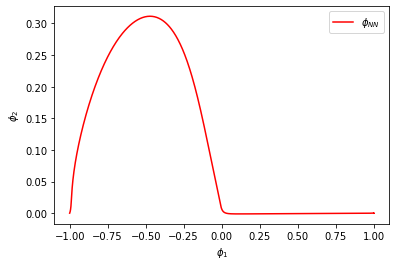

In [19]:
fig=  plt.figure()
plt.plot(phi_opt[0],phi_opt[1],'r', label='$\phi_{NN}$' ) 
plt.xlabel('$\phi_1$')
plt.ylabel('$\phi_2$')
plt.legend()
plt.show()
#fig.savefig('2d_phi_T'+str(t1)+'_alpha'+str(alpha)+'_end_100total_dw.png')

In [ ]:
fig=  plt.figure()
plt.plot(phi_t0[0],phi_t0[1],'r', label='$\phi_{NN}$' ) 
plt.xlabel('$\phi_1$')
plt.ylabel('$\phi_2$')
plt.legend()
plt.show()
#fig.savefig('2d_phi_T'+str(t1)+'_alpha'+str(alpha)+'_end_100total_dw.png')

In [ ]:
fig=  plt.figure()
plt.plot(vect,phi_t0[0],'r', label='$\phi_{1NN}$' ) 
plt.plot(vect,phi_t0[1],'g', label='$\phi_{2NN}$' ) 
plt.xlabel('$t$')
plt.ylabel('$\phi$')
plt.legend()
plt.show()
#fig.savefig('2d_phi_T'+str(t1)+'_alpha'+str(alpha)+'_end_100total_dw.png')

In [ ]:
fig=  plt.figure()
plt.plot(vect,phi_opt[0],'r', label='$\phi_{NN}$' )
plt.xlabel('$t$')
plt.ylabel('$\phi_0$')
plt.legend()
plt.show()
#fig.savefig('2d_phi_T'+str(t1)+'_alpha'+str(alpha)+'_opt_100total_dw.png')

In [ ]:
fig=  plt.figure()
plt.plot(vect,phi_opt[1],'r', label='$\phi_{NN}$' )
plt.xlabel('$t$')
plt.ylabel('$\phi_1$')
plt.legend()
plt.show()
#fig.savefig('2d_phi_T'+str(t1)+'_alpha'+str(alpha)+'_opt_100total_dw.png')

In [ ]:
plt.plot(vect,g_t0[0])

In [ ]:
plt.plot(vect,g_t0[1])